In [9]:
!pip install wandb --quiet
!pip install swig --quiet
!pip install gym[all] --quiet
!pip install pygame --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:

In [10]:
import gym
import numpy as np
import torch
import random
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
# Define a simple policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gamma=0.99, lr=0.001):
        super(PolicyNetwork, self).__init__()
        self.lr = lr
        self.gamma = gamma
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)
        self.optimizer = optim.Adam(self.parameters(),lr=self.lr)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = self.l2(x)
        return torch.softmax(x, dim=-1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Function to collect trajectories
def collect_trajectories(policy_network, env):
    trajectories = []
    total_reward = 0
    timesteps = 0
    episode = {'states': [], 'actions': [], 'rewards': []}
    state = env.reset()
    done = False
    while not done:
      timesteps += 1
      state = torch.tensor(state, dtype=torch.float32)
      action_probs = policy_network(state)
      action_dist = Categorical(action_probs)
      action = action_dist.sample()
      next_state, reward, done, _ = env.step(action.item())
      total_reward += reward
      timesteps += 1
      episode['states'].append(state)
      episode['actions'].append(action)
      episode['rewards'].append(reward)
      state = next_state
    #print("Reward: {}".format(total_reward))

    trajectories.append(episode)
    return trajectories, total_reward, timesteps  #returns total reward and timesteps per episode

In [4]:
# Function to compute discounted rewards
def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    running_add = 0
    for r in reversed(rewards):
        running_add = running_add * gamma + r
        discounted_rewards.insert(0, running_add)
    return discounted_rewards

In [5]:
# Function to update the policy network
def update_with_baseline(policy_network, trajectories, gamma):
    for episode in trajectories:
        loss = 0
        discounted_rewards = compute_discounted_rewards(episode['rewards'], gamma)
        baseline = np.mean(discounted_rewards)
        for state, action, dr in zip(episode['states'], episode['actions'], discounted_rewards):
            action_probs = policy_network(state)
            action_dist = Categorical(action_probs)
            log_prob = action_dist.log_prob(action)
            advantage = dr - baseline
            loss -= log_prob * advantage

            #loss -= log_prob * dr
        #total_loss = loss / len(trajectories)
        policy_network.optimizer.zero_grad()
        loss.backward()
        policy_network.optimizer.step()

In [6]:
def update_without_baseline(policy_network, trajectories, gamma):
    for episode in trajectories:
        loss = 0
        discounted_rewards = compute_discounted_rewards(episode['rewards'], gamma)
        #baseline = np.mean(discounted_rewards)
        for state, action, dr in zip(episode['states'], episode['actions'], discounted_rewards):
            action_probs = policy_network(state)
            action_dist = Categorical(action_probs)
            log_prob = action_dist.log_prob(action)
            #advantage = dr - baseline
            loss -= log_prob * dr

            #loss -= log_prob * dr
        #total_loss = loss / len(trajectories)
        policy_network.optimizer.zero_grad()
        loss.backward()
        policy_network.optimizer.step()

In [14]:
# Main function for training
def train():
    # Set up environment
    random.seed(350)
    env = gym.make('LunarLander-v2')
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    hidden_dim = 256
    # Hyperparameters
    n_episodes = 100
    episode_array = [i for i in range(1,n_episodes+1)]
    gamma = 0.99
    target_update = 10

    policy_network_1 = PolicyNetwork(input_dim, hidden_dim, output_dim, lr=0.001)
    rewards_array_1 = []
    timesteps_1 = []
    mean_rewards_list_1 = []
    #batch_size = 20
    #print("{}".format(math.floor(n_episodes/batch_size)))
     # Training loop
    for episode in range(n_episodes):
        #print("episode: {}".format((episode+1) * (n_episodes/batch_size) ))
        trajectories, rewards, timesteps = collect_trajectories(policy_network_1, env)
        update_without_baseline(policy_network_1, trajectories, gamma)
        timesteps_1.append(timesteps)
        rewards_array_1.append(rewards)
        #trajectories_1.extend(trajectories)

        #print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))
        if episode % target_update == 0:
            reward = np.mean(rewards_array_1[episode-10:episode])
            print("Episode:{}".format(episode))
            print("Mean Reward:{}".format(reward))
            episode_array.append(episode)
            mean_rewards_list_1.append(reward)


    policy_network_2 = PolicyNetwork(input_dim, hidden_dim, output_dim, lr=0.01)
    rewards_array_2 = []
    timesteps_2 = []
    mean_rewards_list_2 = []
    for episode in range(n_episodes):
        #print("episode: {}".format((episode+1) * (n_episodes/batch_size) ))
        trajectories, rewards, timesteps = collect_trajectories(policy_network_2, env)
        update_without_baseline(policy_network_2, trajectories, gamma)
        timesteps_2.append(timesteps)
        rewards_array_2.append(rewards)
        #trajectories_1.extend(trajectories)

       # print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))
        if episode % target_update == 0:
            reward = np.mean(rewards_array_2[episode-10:episode])
            print("Episode:{}".format(episode))
            print("Mean Reward:{}".format(reward))
            episode_array.append(episode)
            mean_rewards_list_2.append(reward)


    policy_network_3 = PolicyNetwork(input_dim,hidden_dim, output_dim, lr=0.1)
    rewards_array_3 = []
    timesteps_3 = []
    mean_rewards_list_3 = []
    for episode in range(n_episodes):
        #print("episode: {}".format((episode+1) * (n_episodes/batch_size) ))
        trajectories, rewards, timesteps = collect_trajectories(policy_network_3, env)
        update_without_baseline(policy_network_3, trajectories, gamma)
        timesteps_3.append(timesteps)
        rewards_array_3.append(rewards)
        #trajectories_1.extend(trajectories)

        #print("Episode {}: Total Reward: {:.2f} Timesteps: {}".format(episode + 1, rewards, timesteps))
        if episode % target_update == 0:
            reward = np.mean(rewards_array_3[episode-10:episode])
            print("Episode:{}".format(episode))
            print("Mean Reward:{}".format(reward))
            episode_array.append(episode)
            mean_rewards_list_3.append(reward)

    plt.title("Performance of REINFORCE in Lunar Lander")
    plt.plot(episode_array, rewards_array_1, label = "lr = 0.001")
    plt.plot(episode_array, rewards_array_2, label = "lr = 0.01")
    plt.plot(episode_array, rewards_array_3, label = "lr = 0.1")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.legend()
    plt.show()

    plt.title("Performance of REINFORCE in Lunar Lander")
    plt.plot(episode_array, mean_rewards_list_1, label = "lr = 0.001")
    plt.plot(episode_array, mean_rewards_list_2, label = "lr = 0.01")
    plt.plot(episode_array, mean_rewards_list_3, label = "lr = 0.1")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.legend()
    plt.show()

    plt.title("Performance of REINFORCE in Lunar Lander")
    plt.plot(episode_array, timesteps_1, label = "lr = 0.001")
    plt.plot(episode_array, timesteps_2, label = "lr = 0.01")
    plt.plot(episode_array, timesteps_3, label = "lr = 0.1")
    plt.xlabel("Episodes")
    plt.ylabel("Timesteps")
    plt.legend()
    plt.show()

    env.close()


Episode:0
Mean Reward:nan
Episode:10
Mean Reward:-159.95525953073079
Episode:20
Mean Reward:-218.13206001410973
Episode:30
Mean Reward:-358.7469252359992
Episode:40
Mean Reward:-243.66491695494386
Episode:50
Mean Reward:-182.347218782095
Episode:60
Mean Reward:-200.27870338240345
Episode:70
Mean Reward:-190.0321472062423
Episode:80
Mean Reward:-179.20830677351688
Episode:90
Mean Reward:-168.5781377469075
Episode:0
Mean Reward:nan
Episode:10
Mean Reward:-143.1061554482531
Episode:20
Mean Reward:-124.836122586373
Episode:30
Mean Reward:-129.98198267027718
Episode:40
Mean Reward:-134.11480866225182
Episode:50
Mean Reward:-147.21381301875198
Episode:60
Mean Reward:-154.97149169179528
Episode:70
Mean Reward:-124.86547624921081
Episode:80
Mean Reward:-130.10266012978485
Episode:90
Mean Reward:-113.25067314988264
Episode:0
Mean Reward:nan
Episode:10
Mean Reward:-427.8786357067446
Episode:20
Mean Reward:-816.3327128165122
Episode:30
Mean Reward:-1030.4476824603307
Episode:40
Mean Reward:-1148.

ValueError: x and y must have same first dimension, but have shapes (130,) and (100,)

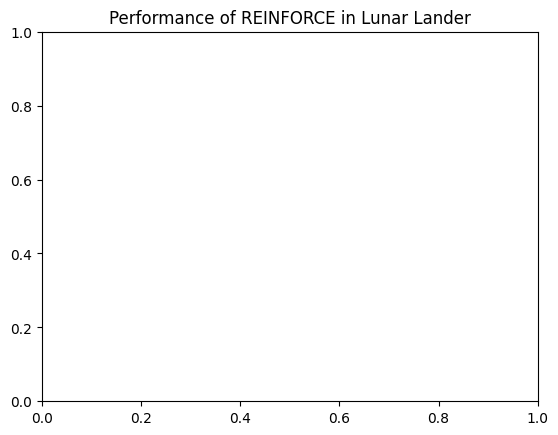

In [15]:
# Run the training
train()